# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a simple [linear regression model](https://scikit-learn.org/stable/modules/linear_model.html)
        - An advanced regressor of your choice (e.g., Random Forest, Neural Network, etc.)

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Assuming that the files `adult.data` and `adult.test` are in `../data/adult/`, then you can use the code below to load them.

In [5]:
import pandas as pd
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('/Users/Zhiyang/DSI/scaling_to_production/05_src/data/fires/forestfires.csv', header = None, names = columns, skiprows=1))


In [6]:
fires_dt.head(n = 5)

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [7]:
fires_dt.sample(n = 5)

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
310,7,4,sep,sun,92.4,105.8,758.1,9.9,25.3,27,2.7,0.0,0.00
434,1,4,aug,fri,90.6,269.8,811.2,5.5,22.2,45,3.6,0.0,0.00
199,2,4,sep,mon,63.5,70.8,665.3,0.8,22.6,38,3.6,0.0,11.32
259,7,4,aug,sat,91.8,170.9,692.3,13.7,23.7,40,1.8,0.0,1.38
347,5,4,sep,fri,92.1,99.0,745.3,9.6,10.1,75,3.6,0.0,0.00


In [8]:
type(fires_dt['rh'][0])

numpy.int64

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
import pandas as pd

from sklearn.model_selection import cross_validate


# Get X and Y

Create the features data frame and target data.

In [10]:
X = fires_dt.drop(columns = 'area')
Y = fires_dt['area']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [11]:
# preproc1
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']

preproc1 = ColumnTransformer(
    transformers=[('num_trans', RobustScaler(), numeric_features),
                  ('cat_trans', OneHotEncoder(handle_unknown='ignore'), categorical_features)])


In [12]:
preproc1

ColumnTransformer(transformers=[('num_trans', RobustScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_trans',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [13]:
# preproc2
from sklearn.preprocessing import PowerTransformer

preproc2 = ColumnTransformer(
    transformers=[('num_trans', Pipeline([('scaler', StandardScaler()),
                                          ('transformer', PowerTransformer(method='yeo-johnson'))]), numeric_features),
                  ('cat_trans', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

In [14]:
preproc2

ColumnTransformer(transformers=[('num_trans',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('transformer',
                                                  PowerTransformer())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_trans',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

In [15]:
preproc1.get_params()

{'force_int_remainder_cols': True,
 'n_jobs': None,
 'remainder': 'drop',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('num_trans',
   RobustScaler(),
   ['coord_x',
    'coord_y',
    'ffmc',
    'dmc',
    'dc',
    'isi',
    'temp',
    'rh',
    'wind',
    'rain']),
  ('cat_trans', OneHotEncoder(handle_unknown='ignore'), ['month', 'day'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'num_trans': RobustScaler(),
 'cat_trans': OneHotEncoder(handle_unknown='ignore'),
 'num_trans__copy': True,
 'num_trans__quantile_range': (25.0, 75.0),
 'num_trans__unit_variance': False,
 'num_trans__with_centering': True,
 'num_trans__with_scaling': True,
 'cat_trans__categories': 'auto',
 'cat_trans__drop': None,
 'cat_trans__dtype': numpy.float64,
 'cat_trans__feature_name_combiner': 'concat',
 'cat_trans__handle_unknown': 'ignore',
 'cat_trans__max_categories': None,
 'cat_trans__min_frequency': None,
 'cat_trans__sparse_output': True}

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [16]:
# Pipeline A = preproc1 + baseline
pipeline_A = Pipeline([('preprocessing', preproc1),('regressor', LinearRegression())])

In [17]:
# Pipeline B = preproc2 + baseline
pipeline_B = Pipeline([('preprocessing', preproc2),('regressor', LinearRegression())])

In [18]:
# Pipeline C = preproc1 + advanced model
# I am going to use random forest
from sklearn.ensemble import RandomForestRegressor

pipeline_C = Pipeline([('preprocessing', preproc1),('regressor', RandomForestRegressor())])

In [19]:
# Pipeline D = preproc2 + advanced model
pipeline_D = Pipeline([('preprocessing', preproc2),('regressor', RandomForestRegressor())])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [20]:
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'r2': 'r2',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'explained_variance': 'explained_variance'
}

In [21]:
# Pipeline A = preproc1 + baseline
# pipeline_A = Pipeline([('preprocessing', preproc1),('regressor', LinearRegression())])

param_grid_A = {'regressor__fit_intercept': [True, False]}
#Grid Search with Cross-Validation
grid_search_A = GridSearchCV(pipeline_A, param_grid_A, cv=5, 
                             scoring=scoring, n_jobs=-1, refit='neg_mean_squared_error')
grid_search_A.fit(X_train, Y_train)


result_A = pd.DataFrame(grid_search_A.cv_results_)

result_A[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
             'param_regressor__fit_intercept', 'params',
             'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
             'mean_test_r2', 'std_test_r2',
             'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
             'mean_test_explained_variance', 'std_test_explained_variance',
             'rank_test_neg_mean_squared_error']].sort_values('rank_test_neg_mean_squared_error')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,params,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,mean_test_r2,std_test_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,mean_test_explained_variance,std_test_explained_variance,rank_test_neg_mean_squared_error
1,0.032978,0.002925,0.014940,0.004414,False,{'regressor__fit_intercept': False},-2230.631971,2554.442860,-0.316265,0.299797,-18.470650,3.061057,-0.275038,0.264917,1
0,0.050371,0.021014,0.015397,0.003269,True,{'regressor__fit_intercept': True},-2230.724512,2555.733362,-0.315601,0.299924,-18.486499,3.113984,-0.274489,0.265103,2


In [22]:
print(grid_search_A.best_params_)
print(grid_search_A.best_score_)

{'regressor__fit_intercept': False}
-2230.63197062561


In [23]:
best_params_A = grid_search_A.best_params_

pipeline_A.set_params(**best_params_A)

res_A = cross_validate(pipeline_A, X_train, Y_train, cv = 5, scoring = scoring)
res_A = pd.DataFrame(res_A).assign(experiment = 'Pipeline A')
res_A

,fit_time,score_time,test_neg_mean_squared_error,test_r2,test_neg_mean_absolute_error,test_explained_variance,experiment
0,0.033252,0.082252,-1662.742068,-0.019267,-17.735800,-0.018606,Pipeline A
1,0.073827,0.026294,-383.302544,-0.771829,-15.896232,-0.636624,Pipeline A
2,0.092713,0.016657,-1113.391778,-0.545676,-18.571048,-0.539783,Pipeline A
3,0.052502,0.064785,-7268.207471,-0.008803,-24.229855,-0.000926,Pipeline A
4,0.074663,0.069193,-725.515992,-0.235750,-15.920315,-0.179251,Pipeline A


In [24]:
# Pipeline B = preproc2 + baseline
# pipeline_B = Pipeline([('preprocessing', preproc2),('regressor', LinearRegression())])

param_grid_B = {'regressor__fit_intercept': [True, False]}
#Grid Search with Cross-Validation
grid_search_B = GridSearchCV(pipeline_B, param_grid_B, cv=5, scoring=scoring, n_jobs=-1, refit='neg_mean_squared_error')
grid_search_B.fit(X_train, Y_train)


result_B = pd.DataFrame(grid_search_B.cv_results_)

result_B[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
          'param_regressor__fit_intercept', 'params',
          'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
          'mean_test_r2', 'std_test_r2',
          'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
          'mean_test_explained_variance', 'std_test_explained_variance',
          'rank_test_neg_mean_squared_error']].sort_values('rank_test_neg_mean_squared_error')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,params,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,mean_test_r2,std_test_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,mean_test_explained_variance,std_test_explained_variance,rank_test_neg_mean_squared_error
0,0.087239,0.038408,0.025738,0.015056,True,{'regressor__fit_intercept': True},-2162.046592,2563.343980,-0.249908,0.322289,-18.183584,2.961230,-0.212361,0.269501,1
1,0.133180,0.021891,0.057508,0.025786,False,{'regressor__fit_intercept': False},-2162.087189,2563.789602,-0.249689,0.322310,-18.168121,2.974639,-0.212367,0.269492,2


In [25]:
print(grid_search_B.best_params_)
print(grid_search_B.best_score_)

{'regressor__fit_intercept': True}
-2162.0465924854166


In [26]:
best_params_B = grid_search_B.best_params_

pipeline_B.set_params(**best_params_B)

res_B = cross_validate(pipeline_B, X_train, Y_train, cv = 5, scoring = scoring)
res_B = pd.DataFrame(res_B).assign(experiment = 'Pipeline B')
res_B

,fit_time,score_time,test_neg_mean_squared_error,test_r2,test_neg_mean_absolute_error,test_explained_variance,experiment
0,0.206544,0.102970,-1628.193087,0.001912,-18.374949,0.002778,Pipeline B
1,0.164141,0.034698,-404.990579,-0.872082,-16.022395,-0.728397,Pipeline B
2,0.096890,0.015395,-849.476143,-0.179293,-17.086267,-0.178616,Pipeline B
3,0.062360,0.012377,-7224.617856,-0.002753,-23.793262,0.004133,Pipeline B
4,0.058948,0.013878,-702.955298,-0.197323,-15.641050,-0.161701,Pipeline B


In [27]:
# Pipeline C = preproc1 + advanced model
# I am going to use random forest
# pipeline_C = Pipeline([('preprocessing', preproc1),('regressor', RandomForestRegressor())])

#the parameter grid for GridSearchCV
param_grid_C = {
    'regressor__n_estimators': [50, 100, 200], #I tried 300 it's too much for my laptop
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

#Grid Search with Cross-Validation
grid_search_C = GridSearchCV(pipeline_C, param_grid_C, cv=5, scoring=scoring, refit='neg_mean_squared_error')
grid_search_C.fit(X_train, Y_train)

result_C = pd.DataFrame(grid_search_C.cv_results_)

result_C[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
          'param_regressor__n_estimators', 'param_regressor__max_depth', 
          'param_regressor__min_samples_split', 'param_regressor__min_samples_leaf', 'params',
          'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2',
          'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
          'mean_test_explained_variance', 'std_test_explained_variance',
          'rank_test_neg_mean_squared_error']].sort_values('rank_test_neg_mean_squared_error')


/Users/Zhiyang/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Zhiyang/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Zhiyang/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/Zhiyang/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py", line 476, in fit
    self._f

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_estimators,param_regressor__max_depth,param_regressor__min_samples_split,param_regressor__min_samples_leaf,params,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,mean_test_r2,std_test_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,mean_test_explained_variance,std_test_explained_variance,rank_test_neg_mean_squared_error
132,0.077742,0.001153,0.010684,0.000407,50,10.0,10,4,"{'regressor__max_depth': 10, 'regressor__max_f...",-2135.049437,2556.157648,-0.181343,0.248151,-16.250738,3.769717,-0.129813,0.159954,1
315,0.076378,0.002408,0.009924,0.000758,50,30.0,2,4,"{'regressor__max_depth': 30, 'regressor__max_f...",-2137.425873,2569.750585,-0.177786,0.241480,-16.291761,3.612770,-0.137125,0.174389,2
52,0.144560,0.001115,0.012054,0.000625,100,NaN,10,4,"{'regressor__max_depth': None, 'regressor__max...",-2137.860899,2533.394900,-0.226903,0.327357,-16.655582,3.561588,-0.169308,0.228374,3
294,0.078222,0.001173,0.009956,0.001238,50,30.0,10,4,"{'regressor__max_depth': 30, 'regressor__max_f...",-2137.949818,2544.688293,-0.180538,0.203099,-16.519360,3.466391,-0.137770,0.144211,4
74,0.270711,0.001596,0.018156,0.000649,200,NaN,2,4,"{'regressor__max_depth': None, 'regressor__max...",-2138.230610,2544.212861,-0.187864,0.238252,-16.592778,3.448283,-0.134656,0.150906,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,0.010720,0.000590,0.000000,0.000000,50,20.0,10,1,"{'regressor__max_depth': 20, 'regressor__max_f...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,217
169,0.010571,0.000778,0.000000,0.000000,100,20.0,10,1,"{'regressor__max_depth': 20, 'regressor__max_f...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,217
170,0.010619,0.001188,0.000000,0.000000,200,20.0,10,1,"{'regressor__max_depth': 20, 'regressor__max_f...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,217
163,0.011101,0.000362,0.000000,0.000000,100,20.0,2,1,"{'regressor__max_depth': 20, 'regressor__max_f...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,217


In [28]:
print(grid_search_C.best_params_)
print(grid_search_C.best_score_)

{'regressor__max_depth': 10, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 50}
-2135.0494374064433


In [29]:
best_params_C = grid_search_C.best_params_

pipeline_C.set_params(**best_params_C)

res_C = cross_validate(pipeline_C, X_train, Y_train, cv = 5, scoring = scoring)
res_C = pd.DataFrame(res_C).assign(experiment = 'Pipeline C')
res_C

,fit_time,score_time,test_neg_mean_squared_error,test_r2,test_neg_mean_absolute_error,test_explained_variance,experiment
0,0.183129,0.013361,-1733.008312,-0.062340,-17.373673,-0.062147,Pipeline C
1,0.103872,0.011457,-443.567103,-1.050404,-15.265926,-0.771224,Pipeline C
2,0.078690,0.008923,-846.540535,-0.175217,-15.809281,-0.175033,Pipeline C
3,0.080874,0.011590,-7206.565200,-0.000247,-22.899660,0.007852,Pipeline C
4,0.078256,0.008931,-666.574121,-0.135356,-12.878785,-0.105025,Pipeline C


In [30]:
# Pipeline D = preproc2 + advanced model
# also random forest
# pipeline_D = Pipeline([('preprocessing', preproc2),('regressor', RandomForestRegressor())])

#the parameter grid for GridSearchCV
param_grid_D = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

#Grid Search with Cross-Validation
grid_search_D = GridSearchCV(pipeline_D, param_grid_D, cv=5, scoring=scoring, n_jobs=-1, refit='neg_mean_squared_error')
grid_search_D.fit(X_train, Y_train)

result_D = pd.DataFrame(grid_search_D.cv_results_)

result_D[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
          'param_regressor__n_estimators', 'param_regressor__max_depth', 
          'param_regressor__min_samples_split', 'param_regressor__min_samples_leaf', 'params',
          'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2',
          'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
          'mean_test_explained_variance', 'std_test_explained_variance',
          'rank_test_neg_mean_squared_error']].sort_values('rank_test_neg_mean_squared_error')

/Users/Zhiyang/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
261 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Zhiyang/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Zhiyang/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/Zhiyang/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py", line 476, in fit
    self._f

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_estimators,param_regressor__max_depth,param_regressor__min_samples_split,param_regressor__min_samples_leaf,params,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,mean_test_r2,std_test_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,mean_test_explained_variance,std_test_explained_variance,rank_test_neg_mean_squared_error
240,0.416129,0.130294,0.088394,0.082459,50,20.0,10,4,"{'regressor__max_depth': 20, 'regressor__max_f...",-2137.667113,2520.681802,-0.207556,0.255763,-16.504263,3.316081,-0.154855,0.175455,1
154,0.369045,0.006648,0.028703,0.002104,100,10.0,2,4,"{'regressor__max_depth': 10, 'regressor__max_f...",-2141.943760,2573.464861,-0.180023,0.249841,-16.413022,3.783354,-0.130683,0.166411,2
316,0.342027,0.012290,0.026820,0.002015,100,30.0,2,4,"{'regressor__max_depth': 30, 'regressor__max_f...",-2142.489583,2534.718302,-0.233017,0.339401,-16.793718,3.479635,-0.170749,0.230657,3
317,0.625644,0.002872,0.044662,0.004552,200,30.0,2,4,"{'regressor__max_depth': 30, 'regressor__max_f...",-2142.805852,2572.487462,-0.170328,0.207595,-16.381919,3.448096,-0.123921,0.136622,4
46,0.370898,0.014509,0.030163,0.002779,100,NaN,2,4,"{'regressor__max_depth': None, 'regressor__max...",-2143.830213,2537.008424,-0.232334,0.325423,-16.677502,3.491831,-0.177954,0.234643,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,0.084188,0.005024,0.000000,0.000000,200,20.0,5,1,"{'regressor__max_depth': 20, 'regressor__max_f...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,217
168,0.070472,0.004187,0.000000,0.000000,50,20.0,10,1,"{'regressor__max_depth': 20, 'regressor__max_f...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,217
169,0.064698,0.005869,0.000000,0.000000,100,20.0,10,1,"{'regressor__max_depth': 20, 'regressor__max_f...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,217
162,0.064877,0.002895,0.000000,0.000000,50,20.0,2,1,"{'regressor__max_depth': 20, 'regressor__max_f...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,217


In [31]:
print(grid_search_D.best_params_)
print(grid_search_D.best_score_)

{'regressor__max_depth': 20, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 50}
-2137.6671131636504


In [32]:
best_params_D = grid_search_D.best_params_

pipeline_D.set_params(**best_params_D)

res_D = cross_validate(pipeline_D, X_train, Y_train, cv = 5, scoring = scoring)
res_D = pd.DataFrame(res_D).assign(experiment = 'Pipeline D')
res_D

,fit_time,score_time,test_neg_mean_squared_error,test_r2,test_neg_mean_absolute_error,test_explained_variance,experiment
0,0.180431,0.016473,-1700.418357,-0.042362,-17.805232,-0.042334,Pipeline D
1,0.099247,0.011711,-496.890287,-1.296892,-16.092421,-0.940589,Pipeline D
2,0.103631,0.014290,-778.624130,-0.080932,-15.240934,-0.078801,Pipeline D
3,0.103435,0.012302,-7287.453091,-0.011474,-23.168488,-0.003277,Pipeline D
4,0.096348,0.011919,-639.934057,-0.089981,-12.113522,-0.070416,Pipeline D


# Evaluate

+ Which model has the best performance?

In [33]:
combined_results = pd.concat([res_A, res_B, res_C, res_D])

mean_scores = combined_results.groupby('experiment').mean().reset_index()

mean_scores

,experiment,fit_time,score_time,test_neg_mean_squared_error,test_r2,test_neg_mean_absolute_error,test_explained_variance
0,Pipeline A,0.065391,0.051836,-2230.631971,-0.316265,-18.470650,-0.275038
1,Pipeline B,0.117776,0.035864,-2162.046592,-0.249908,-18.183584,-0.212361
2,Pipeline C,0.104964,0.010852,-2179.251054,-0.284713,-16.845465,-0.221115
3,Pipeline D,0.116618,0.013339,-2180.663984,-0.304328,-16.884119,-0.227084


According to above results, Pipeline B (preproc2 and linear model) shows the best performance across all metrics: \
Pipeline B has the lowest Mean Squared Error, highest R-squared value and Explained Variance, while Pipeline C shows the best Mean Absolute Error.\
Despite taking longer to fit and score, Pipeline B demonstrates better performance compared to the other pipelines. 

In my opinion, the linear model performs better than random forest may due to the strong linearity of the data. Also, Random Forests, being more complex and flexible, might not provide additional benefits and might even overfit.

# Export

+ Save the best performing model to a pickle file.

In [38]:
import joblib

# export pipeline B as the best model
pipeline_B.fit(X_train, Y_train)

joblib.dump(pipeline_B, 'best_model.pkl')

['best_model.pkl']

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [40]:
import shap

print(shap.__version__)

0.46.0


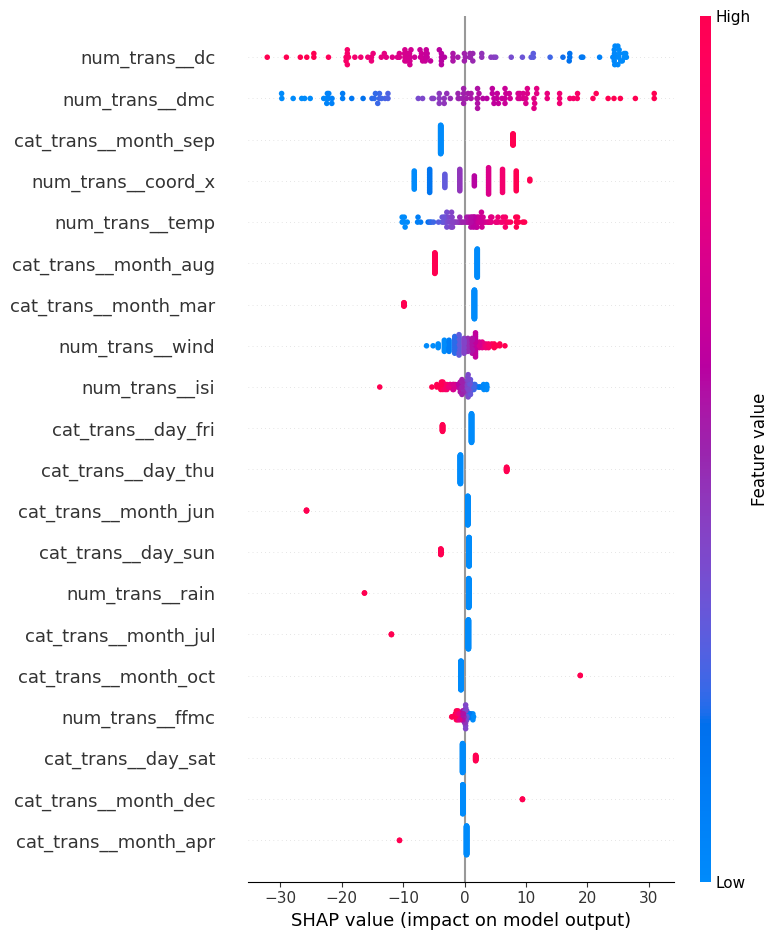

In [41]:
data_transform = pipeline_B.named_steps['preprocessing'].transform(X_test)

explainer = shap.Explainer(pipeline_B.named_steps['regressor'], pipeline_B.named_steps['preprocessing'].transform(X_train))

X_test_transformed = pipeline_B.named_steps['preprocessing'].transform(X_test)

shap_values = explainer(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=pipeline_B['preprocessing'].get_feature_names_out())

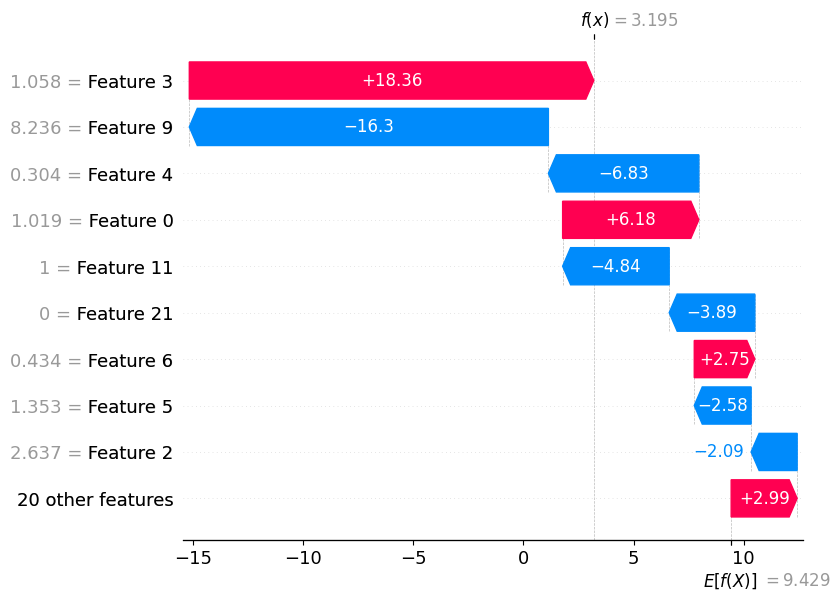

In [57]:
shap.plots.waterfall(shap_values[1])

*(Answer here.)*

1. Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

For the observation at index 1, \
High Impact Features:\
DMC (Feature 3): Increases the prediction by +18.36.\
rain (Feature 9): Decreases the prediction by -16.3.\
DC (Feature 4): Decreases the prediction by -6.83.

2. In general, across the complete training set, which features are the most and least important.

Most Important Features:\
num_trans__dc (Drought Code): High values of dc increase the predicted area, indicating that drought conditions significantly contribute to the severity of forest fires.\
num_trans__dmc (Duff Moisture Code): Higher values of dmc also increase the prediction, suggesting that moisture content in the duff layer is crucial for predicting fire severity.\
cat_trans__month_sep (Month: September): The month of September has higher prediction.

Least Important Features:\
cat_trans__month_apr (Month: April) and cat_trans__month_dec (Month: December) and cat_trans__day_sat (Saturday): indicating in April, December and on Saturday, the forest fires are less significant or frequent.

3. 
+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

Based on the SHAP summary plot, the following features show minimal importance and could be candidates for removal:
cat_trans__month_apr (Month: April), cat_trans__month_dec (Month: December) and cat_trans__day_sat (Day: Saturday) since they have minimal SHAP values, indicating they do not significantly contribute to the model’s predictions.

Removing these features can simplify the model and potentially improve generalization by reducing overfitting.

To test that these features are actually enhancing model performance, I would exclude them form the dataset, and retrain the models, and compare the results.\
I would evaluate the model on the same performance metrics (e.g., Mean Squared Error, R-squared, Mean Absolute Error, Explained Variance).

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.